---
title: "MicroGrad from Scratch with Andrej Karpathy's tutorial"
author: "Jax Bulbrook"
date: "2023-07-25"
categories: [projects]
---

I want to learn how Transformers work in depth, but I need a bit of background first. I am going to do all of the tutorials on Andrej Karpathy's channel, starting with [this micrograd from scratch one](https://www.youtube.com/watch?v=VMj-3S1tku0). That should give me enough background to understand his latest GPT from Scratch tutorial!

In [1]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self.grad = 0 # the derivative of L with respect to this value
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        return out

In [2]:
a = Value(1.5,label='a')
b = Value(-5.5,label='b')
c = Value(0.2,label='c')
a*b,a+b

(Value(data=-8.25), Value(data=-4.0))

In [3]:
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.2,label='f')
L = d*f; L.label = 'L' # the loss function L

In [4]:
d._prev

{Value(data=-8.25), Value(data=0.2)}

In [5]:
d._op

'+'

# Now we want a way to visualize the tree, since there will eventually be many values in the tree.

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

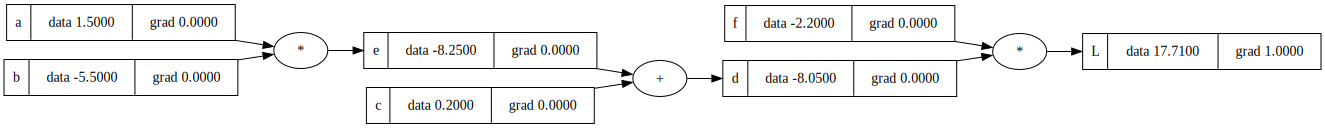

In [12]:
draw_dot(L)

In [10]:
# manual backprop
def lol():
    # the reason this is in a function is because they will be local to this function and therefore not mess up the global scope
    h = 0.001

    a = Value(1.5,label='a')
    b = Value(-5.5,label='b')
    c = Value(0.2,label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.2,label='f')
    L = d*f; L.label = 'L' # the loss function L
    L1 = L.data

    a = Value(1.5,label='a') 
    b = Value(-5.5,label='b')
    c = Value(0.2,label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.2,label='f')
    L = d*f; L.label = 'L' # the loss function L
    L2 = L.data + h # the derivate of L with respect to L, since L is increased by h
    print((L2 - L1)/h)
lol()

1.0000000000012221


In [11]:
L.grad = 1

### L = d * f

##### dL/dd =? f (the derivate of L with respect to d is f)

## Proof:
lim h->0 (f(x+h)-f(x))/h

((d+h) * f - d*f)/h
(d*f + h*f - d*f)/h
(h*f)/h
f

In [13]:
d.grad = f.data
f.grad = d.data

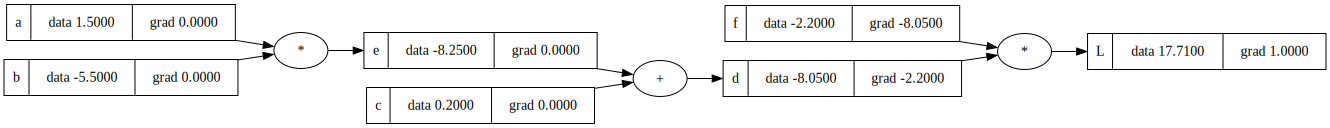

In [14]:
draw_dot(L)

dL / dc 
since we know dL / dd we can get dd / dc and use it to get dL / dc

d = c + e

dd / dc = 1

## Proof
(f(x+h) - f(x)) / h
((c+h + e) - (c + e))/h
(c+h+e-c-e)/h
h/h
1

dd / de = 1 as well

but we need dL / dc
we use the chain rule, which is basically: if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2x4=8 times as fast as the man. So you multiply

WANT dL / dc
KNOW dL/dd and dd/dc

dL / dc = (dL / dd) * (dd / dc) = (dL / dd) * 1 = dL / dd

In [15]:
c.grad = d.grad
e.grad = d.grad

dL / da = (dL / de) * (de / da)

de / da?
de / da = b

dL / da = dL / de * b

In [18]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data

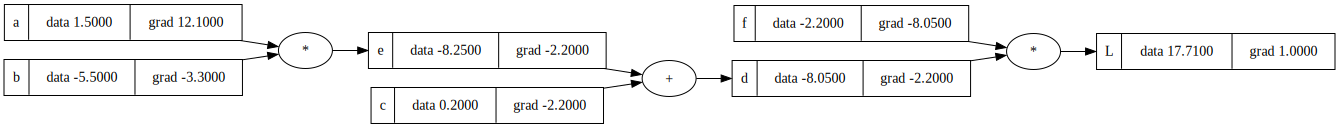

In [19]:
draw_dot(L)

In [20]:
# to try and make L go up, we just have to go in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f
print(L.data)

19.3401846


### It worked! Now we will do an example with a neuron
![image.png](https://www.google.com/url?sa=i&url=https%3A%2F%2Fcs231n.github.io%2Fconvolutional-networks%2F&psig=AOvVaw0qCWOtI8RjnVcLCC5vKp0c&ust=1690894863871000&source=images&cd=vfe&opi=89978449&ved=0CBAQjRxqFwoTCPCLva-AuYADFQAAAAAdAAAAABAE)
Here is the activation function:

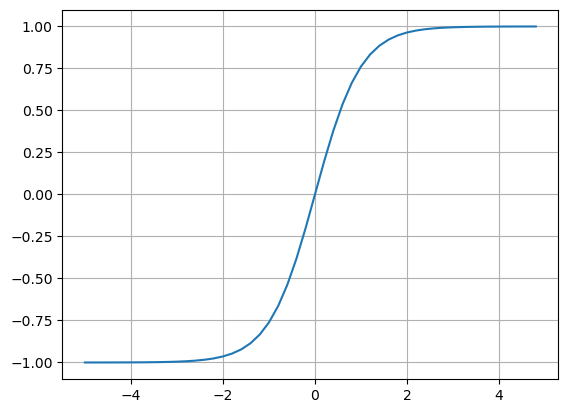

In [24]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

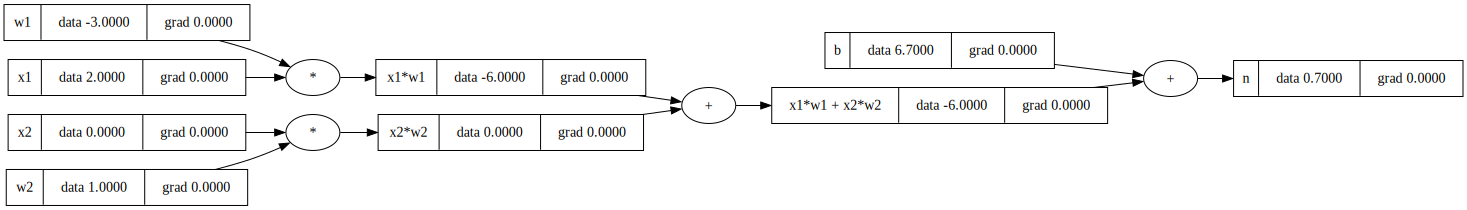

In [25]:
#inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3, label='w1')
w2 = Value(1,label='w2')
# bias of the neuron
b = Value(6.7, label='b')
#x1*w1 + x2*w2+b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)

In [ ]:
# in order to do the activation function tanh, we need to update Value
class Value:
    def __init__(self,data,_children=(),_op='',label=''): #the data is the value, we need children to store the children passed into functions like add and mult, and op to show the operations that came up with those children.
        self.data = data
        self.grad = 0 # the derivative of L with respect to this value
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),"*")
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ), 'tanh')
        return out